In [1]:
import sksurv
import pandas
import math
import numpy as np
from sksurv.linear_model import CoxPHSurvivalAnalysis,CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM
from sksurv.metrics import concordance_index_censored
import os
from sksurv.util import Surv
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)
from sklearn.model_selection import train_test_split, RepeatedKFold
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
import eli5
from eli5.sklearn import PermutationImportance
from matplotlib import pyplot as plt
cwd = os.getcwd()
print(cwd)

C:\Users\Rosha


In [2]:
pathnew=r"C:\Users\Rosha\OneDrive\Documents\Third Year MD\Research\TRIDENT II"
os.chdir(pathnew)
cwd = os.getcwd()
print(cwd)

C:\Users\Rosha\OneDrive\Documents\Third Year MD\Research\TRIDENT II


In [3]:
dataset = pandas.read_csv('Male PK.csv', sep=',')

#%%
y_full = dataset.iloc[:,76:]
x_full = dataset.iloc[:,0:76]
x_full
y_full

#%%
data = np.zeros(2935, dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

data['Censor'] = y_full.iloc[:,0]
data['Survival'] = y_full.iloc[:,1]

y_full = data



In [4]:
#Alpha and feature selection for coxnet models
#Make the max_iter value lower to reduce processing time. Could make it 20
coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
)
warnings.simplefilter("ignore", ConvergenceWarning)
coxnet_pipe.fit(x_full, y_full)

#%%Continued...
#Dont need to run this again as the cv_results dataframe is already saved as 'Coxnet lasso Grid CV'.  Can load from file.
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=0)
gcvlinear = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(x_full, y_full)

#%%
cv_results = pandas.DataFrame(gcvlinear.cv_results_)
cv_results.to_csv('Male_1/Coxnet Lasso Grid CV All.csv')

#%%
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score




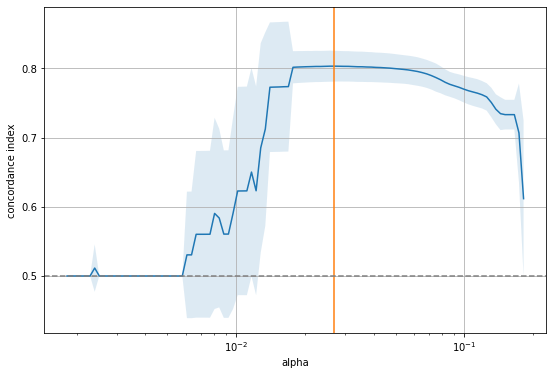

In [5]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcvlinear.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

plt.savefig('Male_1/Alphas graph All.png', dpi=300,  bbox_inches = "tight")



Number of non-zero coefficients: 17


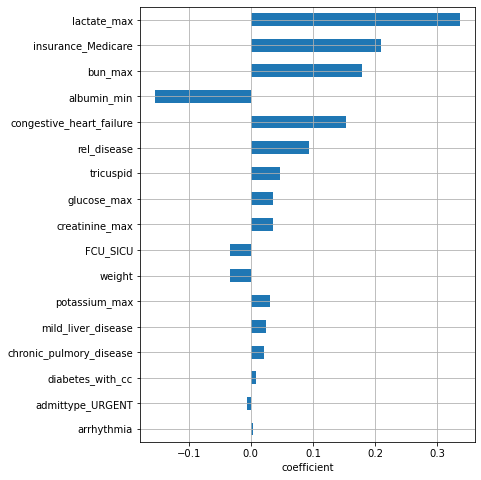

In [6]:
import pandas as pd
best_model = gcvlinear.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=x_full.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

plt.savefig('Male_1/Linear Coefficients All.png', dpi=300,  bbox_inches = "tight")

In [7]:
#%% Evaluating using cross validation
#cv = KFold(n_splits=5, shuffle=True, random_state=0)
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Censor"], y["Survival"], prediction)
    return result[0]
#1. RF
rsf = RandomSurvivalForest(min_samples_leaf=7)

gcvrf = GridSearchCV(
    rsf,
    param_grid = {'max_features': ['log2','auto','sqrt'], 'n_estimators':[100,200,300]},
    cv=cv,
    scoring = score_survival_model,
    n_jobs=4, verbose=2).fit(x_full, y_full)

#2. GBM
gbm = GradientBoostingSurvivalAnalysis()

gcvgbm = GridSearchCV(
    gbm,
    param_grid = {'learning_rate': [1,0.1,0.01], 'n_estimators': [100,200,300]},
    cv=cv,
    scoring = score_survival_model,
    n_jobs=4, verbose = 2).fit(x_full, y_full)

#3. SVM
svm = FastSurvivalSVM(tol=1e-5)

gcvsvm = GridSearchCV(
    svm,
    param_grid = {'max_iter': [20,100,500,1000]},
    cv=cv,
    scoring = score_survival_model,
    n_jobs=4, verbose = 2).fit(x_full, y_full)

#%%
rf_cv_results = pandas.DataFrame(gcvrf.cv_results_)
rf_cv_results.to_csv('Male_1/RF Grid CV With scorer specified.csv')

gbm_cv_results = pandas.DataFrame(gcvgbm.cv_results_)
gbm_cv_results.to_csv('Male_1/GBM Grid CV With scorer specified.csv')

svm_cv_results = pandas.DataFrame(gcvsvm.cv_results_)
svm_cv_results.to_csv('Male_1/SVM Grid CV With scorer specified.csv')

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [8]:
print(gcvrf.best_params_)
print(gcvgbm.best_params_)
print(gcvsvm.best_params_)
print(gcvlinear.best_params_)

{'max_features': 'sqrt', 'n_estimators': 300}
{'learning_rate': 0.1, 'n_estimators': 200}
{'max_iter': 500}
{'coxnetsurvivalanalysis__alphas': [0.02695868616173857]}


In [9]:
rfbestparam = {'max_features': 'log2', 'n_estimators': 100}
gbmbestparam = {'learning_rate': 0.1, 'n_estimators': 200}
svmbestparam = {'max_iter': 100}
coxbestparam = {'coxnetsurvivalanalysis__alphas': [0.018829744298147266]}

In [10]:
#%%
#Time-dependent evaluation
x_train, x_test, y_train, y_test = train_test_split(
    x_full, y_full, test_size=0.1, stratify=y_full["Censor"], random_state=0)

#%%
#Make sure to put optimal model features here
#1. RF
#rsf = RandomSurvivalForest(n_estimators=100, min_samples_leaf=7, random_state=0)
rsf = RandomSurvivalForest(min_samples_leaf=7)
rsf.set_params(**gcvrf.best_params_)
rsf.fit(x_train,y_train)

va_times = np.arange(7, 1460, 7)
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(
    x_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, rsf_risk_scores, va_times
)

#2. GBM
#gbm = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gbm = GradientBoostingSurvivalAnalysis()
gbm.set_params(**gcvgbm.best_params_)
gbm.fit(x_train,y_train)

va_times = np.arange(7, 1460, 7)
gbm_chf_funcs = gbm.predict_cumulative_hazard_function(
    x_test)
gbm_risk_scores = np.row_stack([chf(va_times) for chf in gbm_chf_funcs])

gbm_auc, gbm_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, gbm_risk_scores, va_times
)

#3. SVM
#svm = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)
svm = FastSurvivalSVM(tol=1e-5)
svm.set_params(**gcvsvm.best_params_)
svm.fit(x_train,y_train)

va_times = np.arange(7, 1460, 7)
svm_chf_funcs = svm.predict(
    x_test)
svm_auc, svm_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, svm_chf_funcs, va_times
)

#4. CoxNet
coxnet_pred = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**gcvlinear.best_params_)
coxnet_pred.fit(x_train, y_train)
cph_risk_scores = coxnet_pred.predict(x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, cph_risk_scores, va_times
)


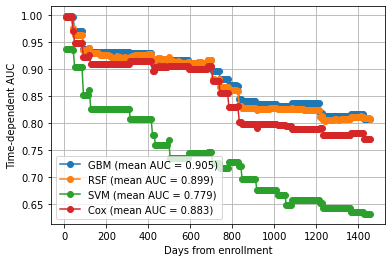

In [11]:
#Plotting time dependent C-Index
import matplotlib.pyplot as plt
plt.plot(va_times, gbm_auc, "o-", label="GBM (mean AUC = {:.3f})".format(gbm_mean_auc))
plt.plot(va_times, rsf_auc, "o-", label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
plt.plot(va_times, svm_auc, "o-", label="SVM (mean AUC = {:.3f})".format(svm_mean_auc))
plt.plot(va_times, cph_auc, "o-", label="Cox (mean AUC = {:.3f})".format(cph_mean_auc))
plt.xlabel("Days from enrollment")
plt.ylabel("Time-dependent AUC")
plt.legend(loc="lower left")
plt.grid(True)

plt.savefig('Male_1/Time dependent AUC.png', dpi=300,  bbox_inches = "tight")


In [12]:
#%%
feature_names = x_full.columns.tolist()
x_train, x_test, y_train, y_test = train_test_split(
    x_full, y_full, test_size=0.1, stratify=y_full["Censor"], random_state=0)


#%%
random_state = 0

rsf = RandomSurvivalForest(min_samples_leaf=7)
rsf.set_params(**gcvrf.best_params_)
rsf.fit(x_train,y_train)
permrsf = PermutationImportance(rsf, n_iter=1, random_state=random_state)
permrsf.fit(x_train, y_train)
#eli5.show_weights(permrsf, feature_names=feature_names, top = 20)

gbm = GradientBoostingSurvivalAnalysis()
gbm.set_params(**gcvgbm.best_params_)
gbm.fit(x_train,y_train)
permgbm = PermutationImportance(gbm, n_iter=1, random_state=random_state)
permgbm.fit(x_train, y_train)
#eli5.show_weights(permgbm, feature_names=feature_names, top = 20)

svm = FastSurvivalSVM(tol=1e-5)
svm.set_params(**gcvsvm.best_params_)
svm.fit(x_train,y_train)
permsvm = PermutationImportance(svm, n_iter=1, random_state=random_state)
permsvm.fit(x_train, y_train)


PermutationImportance(estimator=FastSurvivalSVM(max_iter=500,
                                                optimizer='avltree',
                                                tol=1e-05),
                      n_iter=1, random_state=0)

In [13]:
eli5.show_weights(permrsf, feature_names=feature_names, top = 20)

In [14]:
eli5.show_weights(permgbm, feature_names=feature_names, top = 20)

In [15]:
eli5.show_weights(permsvm, feature_names=feature_names, top = 20)